## Les imports

### Charger la lib popup

In [ ]:
#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    !git pull https://github.com/vincentvigon/RECHERCHE3.git
    %ls
else:
    print("on n'est pas sur colab")

import popup_lib.popup as pop

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 187 (delta 47), reused 168 (delta 28), pack-reused 0
Receiving objects: 100% (187/187), 21.36 MiB | 24.07 MiB/s, done.
Resolving deltas: 100% (47/47), done.
From https://github.com/vincentvigon/RECHERCHE3
 * branch            HEAD       -> FETCH_HEAD
ddqn_lib/  GCN.zip       model_1.h5     Pinns/        transformer/
Euler/     Hamilton/     model_2.h5     popup_lib/
GCN/       Hamilton.zip  model_vNet.h5  sample_data/
Popup loaded!


### Lib standarts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *
import tensorflow as tf

# Principes


Chaque agent possède un état constitué:
* De ses poids (=`weights`) 
* et de ses hyperparamètres (=`famparams`). 

Un agent doit effectuer une optimisation et retourner un score (+grand = +mieux) via sa méthode: 

    optimize_and_return_score(self)->float:

Un agent doit être capable de perturber ses `famparams` via sa méthode: 

    set_and_perturb_famparams(self, famparams, period_count:int)->None:

Attention, le nom de cette méthode décrit ce qu'elle doit faire: l'argument `famparams` sera substitué aux anciens `self.famparams` de l'agent, puis il y aura une perturbation (souvent aléatoire) de ses paramètres. Attention, l'utilisateur qui implémente cette méthode doit faire en sorte que les changements soient "effectifs" (par exemple, si on change le `learning_rate`, il faut que l'`optimizer` soit tenu au courant de ce changement. 


Un `family_trainer` est chargé de trouver un bon état en mettant en concurance des agents, et en les faisant muter (=changer d'état). 


***Echauffement:*** Le `family_trainer` démarre l'échauffement: chaque agent a le droit à un appel de `optimize_and_return_score`. Ensuite s'enchaineront des périodes. 


***Une période:*** Lors d'une période le `family_trainer` lancera les agents successivements. 
* Si `period_duration=10 steps` (par exemple), alors il y aura 10 appels (en tout) de la `optimize_and_return_score`
* Si `period_duration=2 minutes` (ou `30 seconces` par exemple), alors une période durera environ le temps demandé. 

**NB:** Tous les agents de la famille ne lancent pas la méthode `optimize_and_return_score` le même nombre de fois (certains agents la lance 1 fois de plus que d'autres).  Si on veut absolument équilibrer, on peut choisir de prendre `period_duration=n steps` avec `n` un multiple du nombre d'agents. Ou bien mettre une `period_duration` grande (ce qui rend le décalage de $\pm$1 négligeable).


***Les mutations:*** A la fin d'un period: Imaginons que dans  `family_trainer.nb_weak=2` et `family_trainer.nb_strong=2`. Alors les 2 agents les plus faibles recevront les états (`weights` et `famparams`) des 2 agents les plus forts. 

Attention, pour chaque agent il faut distinguer son état courant et sont état à son maximum. 
* La faiblesse d'un agent est déterminée par ses scores récents (par défaut la moyenne des 3 derniers scores, cela peut se changer avec `nb_current_scores` et `current_score_fn`). 
* Le fait qu'un agent soit fort, est basé sur son score à son maximum. Et bien entendu, c'est les `weights` et `famparams` correspondant à son record qui sont transferés aux faibles. 


Option interessante . En mettant `nb_bestweights_averaged=3` (par exemple), un agent fort transferera la moyenne des poids correspondant à ses 3 derniers records. C'est une technique pour limiter le sur-apprentissage. Cela crée des poids une peu "flouté" et plus générique. 




## La décadence


C'est une notion technique. Vous pouvez passer en première lecture. 

Reprenons plus en détail le principe de mutation: 

* les weaks sont les pires agents (selon de leur score courants)
* les decadents sont les meilleurs agents (selon leur score record), mais qui font également partis des weaks
* les strong sont les meilleurs agents (selon leur score record) qui ne sont pas décadent.


Les décadents sont séparés en 2 parties:

         * les décadents-récurrents  sont ceux qui on été trop de fois décadent de manière consécutives. La limite étant l'attribut  `self.max_nb_consecutive_decadence` 
         * les décadents-non-récurrents sont les autres.
         
Voilà ce qui leur arrivent:

         * Les décadents-récurrents repartent de l'état d'un strong aléatoire.
           Leur état record est sauvegardé pour la fin, si l'utilisateur demande de regarder le meilleurs état, 
           y compris parmis les états des décadents-récurrent
        * Les décadents-non-récurrent repartent de leur propre état record. C'est une bonne chose pour lui, car il aura la possibilité d'évoluer ailleurs grâce aux gradients stochastiques. 




***A la fin:***    A la fin de l'apprentissage, le `family_trainer`a une méthode pour récupérer le meilleurs agent: 

    get_best_agent(self, mean_its_weights=False, including_decadent=True)->Abstract_Agent:

Comme on le voit sur la signature, on a la possibilité d'inclure un décadent-récurrent enregistré si son score record est meilleurs que tous les autres. 




## Un exemple ultra simple

Un agent qui cherche a augmenter la somme de ses deux poids.

### Définissons un agent

In [ ]:
class Agent_ultra_toy(pop.Abstract_Agent):

    def __init__(self):
        self.wei0=np.array([0.])
        self.wei1=np.array([0.])
        self.famparams={"add0":0,"add1":0}

    #Abstract_Agent: obligatoire
    def get_famparams(self):
        return self.famparams

    #Abstract_Agent: obligatoire
    def set_and_perturb_famparams(self,famparams,period_count):
        self.famparams=famparams

        self.famparams["add0"]+=np.random.choice([+1,-1])
        self.famparams["add1"]+=np.random.choice([+1,-1])


    def score(self)-> float:
        return self.wei0[0] + self.wei1[0]


    #Abstract_Agent: obligatoire
    def optimize_and_return_score(self) -> float:
        #c'est pas vraiment une optimization ici
        self.wei0 +=self.famparams["add0"]
        self.wei1 +=self.famparams["add1"]
        return self.score()

    #Abstract_Agent: obligatoire
    def set_weights(self, weights):
        self.wei0,self.wei1=weights

    #Abstract_Agent: obligatoire
    def get_copy_of_weights(self):
        return [self.wei0,self.wei1]


    #Abstract_Agent: facultatif: pour ajouter des métriques
    #def to_register_at_period_end(self) ->Dict[str,float]:
    #je ne l'ai pas implémenter pour cet agent


    #Abstract_Agent: facultatif: pour observer les poids
    def to_register_at_period_end(self) ->Dict[str,float]:
        return {"wei0":self.wei0[0],"wei1":self.wei1[0]}


### Entrainons une famille d'agent

In [ ]:
agents=[Agent_ultra_toy(), Agent_ultra_toy()]
family_trainer=pop.Family_trainer(agents,period_duration="10 steps",nb_strong=1)

for _ in range(20):
    family_trainer.period()


fam_1,échauffement a↗0.0b↗0.0
fam_1,period:1 ----------, mutations:a⇇b|
fam_1,period:2 ----------, mutations:a⇇b⇇b|
fam_1,period:3 a↗2.0-a↗4.0-a↗6.0-a↗8.0-a↗10.0-, mutations:b⇇a|
fam_1,period:4 a↗12.0b↗14.0a↗14.0b↗18.0a↗16.0b↗22.0a↗18.0b↗26.0a↗20.0b↗30.0, mutations:a⇇b⇇b⇇b|
fam_1,period:5 a↗34.0b↗34.0a↗38.0b↗38.0a↗42.0b↗42.0a↗46.0b↗46.0a↗50.0b↗50.0, mutations:a⇇b⇇b⇇b⇇b|
fam_1,period:6 a↗56.0b↗54.0a↗62.0b↗58.0a↗68.0b↗62.0a↗74.0b↗66.0a↗80.0b↗70.0, mutations:b⇇a⇇a|
fam_1,period:7 a↗86.0b↗86.0a↗92.0b↗92.0a↗98.0b↗98.0a↗104.0b↗104.0a↗110.0b↗110.0, mutations:a⇇b⇇b⇇b⇇b⇇b|
fam_1,period:8 a↗116.0b↗116.0a↗122.0b↗122.0a↗128.0b↗128.0a↗134.0b↗134.0a↗140.0b↗140.0, mutations:a⇇b⇇b⇇b⇇b⇇b⇇b|
fam_1,period:9 a↗146.0b↗146.0a↗152.0b↗152.0a↗158.0b↗158.0a↗164.0b↗164.0a↗170.0b↗170.0, mutations:a⇇b⇇b⇇b⇇b⇇b⇇b⇇b|
fam_1,period:10 a↗176.0b↗176.0a↗182.0b↗182.0a↗188.0b↗188.0a↗194.0b↗194.0a↗200.0b↗200.0, mutations:a⇇b⇇b⇇b⇇b⇇b⇇b⇇b⇇b|
fam_1,period:11 a↗206.0b↗206.0a↗212.0b↗212.0a↗218.0b↗218.0a↗224.0b↗224.0a↗230.0b↗230.

### Observons les résultats

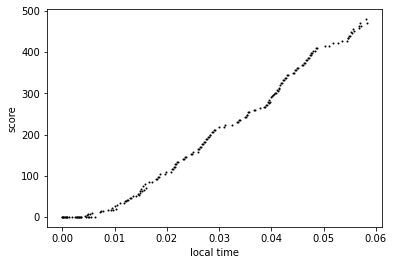

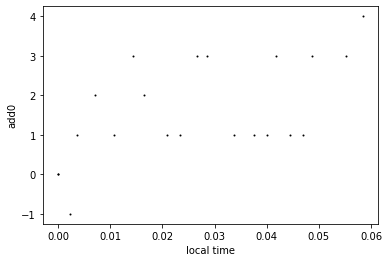

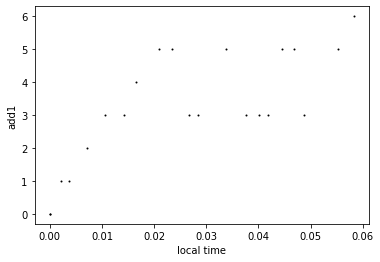

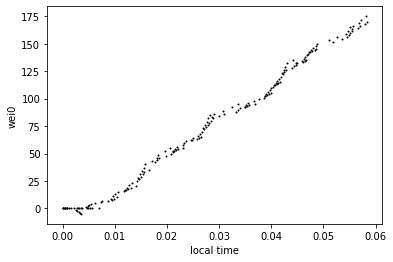

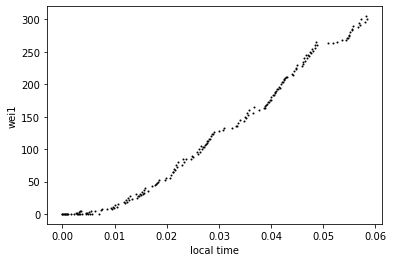

In [ ]:
family_trainer.plot_metric("score")
family_trainer.plot_metric("add0")
family_trainer.plot_metric("add1")

family_trainer.plot_metric("wei0")
family_trainer.plot_metric("wei1")

La moyenne des famparam:

In [ ]:
print("\nstats_of_best:",family_trainer.stats_of_best())


stats_of_best: {'add0': 2.5052631578947366, 'add1': 4.505263157894737}


### Testons le meilleur agent

In [ ]:
best_agent=family_trainer.get_best_agent()
best_agent.score()

480.0

Tout c'est passé comme prévu


## Trouver le minimum d'une fonction

### Présentation du problème

On cherche à minimiser la fonction ci-dessous:

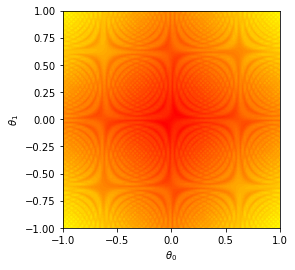

In [ ]:
def loss_fn(x:tf.Variable,y:tf.Variable):
    difficulty=0.5 # avec 0.1 l'optimisation devient très facile
    norm1=tf.abs(x)+tf.abs(y)
    return 3*norm1+ difficulty * (1 - tf.sin( x * y * 500))

def plot_loss_func(ax,r):

    x = np.linspace(-r, r, 100,dtype=np.float32)
    y = np.linspace(-r, r, 100,dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    Q = loss_fn(xx, yy)  ##1.2 - (xx ** 2 + yy ** 2)

    ax.set_aspect('equal')
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.contourf(xx, yy, Q, 50, cmap='autumn')

_,ax=plt.subplots()
plot_loss_func(ax,1)

Elle a comme minimum 0 en (x,y)=(0,0).

On utilise une descente de gradient avec une vitesse différente
pour `x` et pour `y`

En essayant de mettre les paramètres à la main
on trouve pas forcément le minimum car la
fonction à minimiser `loss_fn` a une variabilité locale importante.
Les gradients partent un peu dans tous les sens; mais en moyenne
ils indiquent quand même le bon chemin.

### L'agent

In [ ]:
class Minimizer_agent(pop.Abstract_Agent):

    def __init__(self, custom_set_perturb_famparams):
        #on veut pouvoir créer des agents avec des méthodes de perturbation différentes
        Minimizer_agent.set_and_perturb_famparams=custom_set_perturb_famparams
        self.weight0 = tf.Variable(np.random.uniform(-1,1))
        self.weight1 = tf.Variable(np.random.uniform(-1,1))
        self.famparams={"dir0":np.random.uniform(0,1e-1),"dir1":np.random.uniform(0,1e-1)}

    def get_famparams(self):
        return self.famparams

    def set_famparams(self, dico):
        self.famparams=dico



    def set_and_perturb_famparams(self, famparam, period_count: int) -> None:
        raise Exception("to be defined in the constructor")


    def optimize_and_return_score(self):

        with tf.GradientTape() as tape:
            loss=loss_fn(self.weight0,self.weight1)
        gradients=tape.gradient(loss,[self.weight0,self.weight1])

        self.weight0.assign_sub(gradients[0] * self.famparams["dir0"])
        self.weight1.assign_sub(gradients[1] * self.famparams["dir1"])

        return -loss.numpy()


    def set_weights(self, weights):
        self.weight0.assign(weights[0])
        self.weight1.assign(weights[1])

    def get_copy_of_weights(self):
        return [self.weight0.numpy(),self.weight1.numpy()]

    def to_register_on_mutation(self) ->Dict[str, float]:
        return {"wei0":self.weight0.numpy(),"wei1":self.weight1.numpy()}


### L'agent travail seul

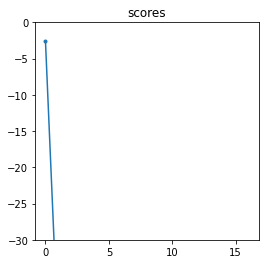

In [ ]:
def minimize_by_hand():
    agent=Minimizer_agent(None)
    scores=[]
    weights0=[]
    weights1 = []
    for _ in range(20):
        score=agent.optimize_and_return_score()
        w0,w1=agent.get_copy_of_weights()
        weights0.append(w0)
        weights1.append(w1)
        scores.append(score)

    fig,ax=plt.subplots(1,1,figsize=(4,4))

    ax.set_title("scores")
    ax.set_ylim(-30,0)
    ax.plot(scores,".-")

    plt.show()
minimize_by_hand()

Normalement, c'est un échec (sauf gros coup de bol)

### En famille

Le familyTrainer s'en sort bien (la plupart du temps).

On définit trois familles:
* La famille `quiet` qui bouge tranquillement ses learning rates
* La famille `exited` qui les bouge beaucoup
* La famille `varying` qui bouge de moins en moins


fam_2,échauffement a↗-1.2477b↗-1.2144c↗-4.2105d↗-5.3408e↗-3.8567f↗-4.6193g↗-2.8501h↗-3.92i↗-2.4725j↗-2.8406
fam_3,échauffement a↗-3.979b↗-2.7979c↗-4.9051d↗-4.289e↗-6.3015f↗-3.7698g↗-4.3996h↗-3.8787i↗-3.3504j↗-3.3092
fam_2,period:1 ----------
/!\ L'agent:d est décadent pour la 1-ième fois consécutive; record:-5.340784072875977, scores courants:deque([-5.340784, -52.562687], maxlen=3), best_famparams: {'dir0': 0.08943866901061151, 'dir1': 0.0643577333784782} 
, mutations:d⇇b|d⇇b↫d|
fam_3,period:1 -b↗-1.9466--------, mutations:c⇇b|
fam_2,period:2 ----------, mutations:c⇇b|
fam_3,period:2 -b↗-1.6994c↗-1.6994-------, mutations:h⇇c|
fam_2,period:3 ---d↗-3.1064------, mutations:g⇇b|
fam_3,period:3 ----------, mutations:f⇇c|
fam_2,period:4 ----------, mutations:j⇇b|
fam_3,period:4 ----------, mutations:d⇇c|
fam_2,period:5 ----------, mutations:e⇇b|
fam_3,period:5 -------h↗-1.4342--, mutations:i⇇h|
fam_2,period:6 ----------, mutations:a⇇b|
fam_3,period:6 --------i↗-2.1844-
/!\ L'agent:e est dé

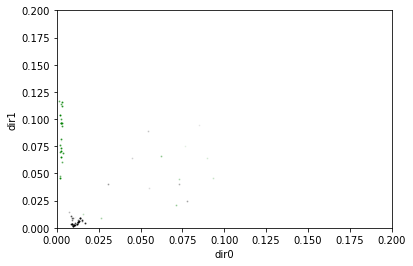

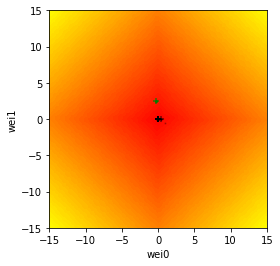

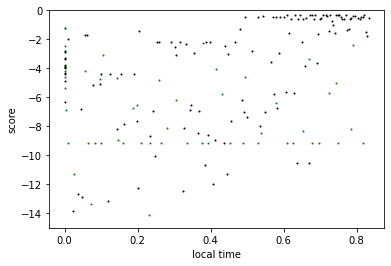

In [ ]:
def main():

    def perturb_quiet(agent:Minimizer_agent,famparams,turn_count):
        agent.famparams=famparams
        agent.famparams["dir0"] *= np.random.uniform(0.8, 1.2)
        agent.famparams["dir1"] *= np.random.uniform(0.8, 1.2)

    def perturb_exited(agent: Minimizer_agent,famparams,turn_count):
        agent.famparams=famparams
        agent.famparams["dir0"] *= np.random.uniform(0.5, 1.5)
        agent.famparams["dir1"] *= np.random.uniform(0.5, 1.5)

    popsize = 10
    quiet_agents = [Minimizer_agent(perturb_quiet) for _ in range(popsize)]
    exited_agents = [Minimizer_agent(perturb_exited) for _ in range(popsize)]


    fam_trainers=[
                  pop.Family_trainer(quiet_agents,
                                 period_duration="10 steps",
                                 color="g"
                                 ),
                  pop.Family_trainer(exited_agents,
                                 period_duration="10 steps",
                                 color="k"
                                 )
                  ]
    try:
        for i in range(20):
            for fm in fam_trainers:fm.period()

    except KeyboardInterrupt:
        print("interuption")

    fig,ax=plt.subplots()
    ax.set_ylim(0,0.2)
    ax.set_xlim(0,0.2)
    for fm in fam_trainers:fm.plot_two_metrics("dir0","dir1",ax)


    fig,ax=plt.subplots()
    r=15
    plot_loss_func(ax,r)
    ax.set_ylim(-r, r)
    ax.set_xlim(-r, r)
    for fm in fam_trainers:
        fm.plot_two_metrics("wei0", "wei1",ax)


    fig, ax = plt.subplots()
    ax.set_ylim(-15, 0)
    for fm in fam_trainers:
        fm.plot_metric("score", ax)

    plt.show()

main()

## Un réseau convolutif

### Les data

4431872/4422102 [==============================] - 0s 0us/step


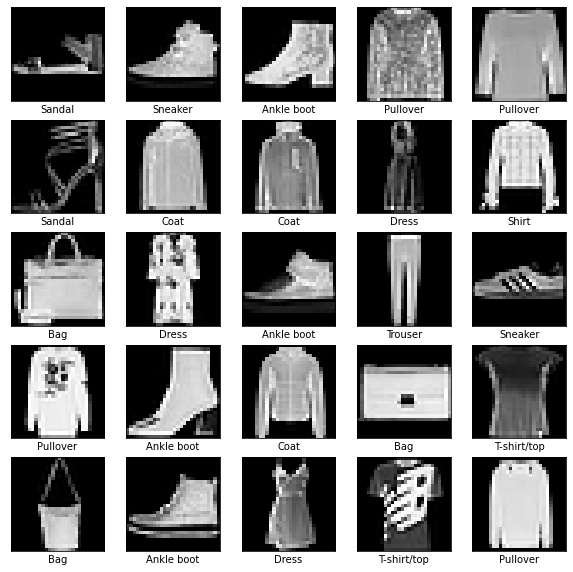

In [ ]:
def present_fashion(X,Y):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.figure(figsize=(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap="gray")
        plt.xlabel(class_names[Y[i]])

    plt.show()

class XY_dealer:

    def __init__(self):
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X_train, Y_train), (X_val_test, Y_val_test) = fashion_mnist.load_data()
        X_train = X_train / 255.0
        X_val_test = X_val_test / 255.0

        nb_val=5000
        self.X_val=X_val_test[:nb_val]
        self.Y_val=Y_val_test[:nb_val]

        self.X_test=X_val_test[nb_val:]
        self.Y_test=Y_val_test[nb_val:]

        self.X_train=X_train
        self.Y_train=Y_train

        self.shuffle()


    def get_XY_val(self):
        perm=np.random.permutation(len(self.X_val))
        return self.X_val[perm[:400]],self.Y_val[perm[:400]]


    def shuffle(self):
        #print("new epoch")
        perm=np.random.permutation(len(self.X_train))

        self.X_train_shuffle=self.X_train[perm]
        self.Y_train_shuffle=self.Y_train[perm]
        self.batch_count=0

    def get_XY_train(self,batch_size):
        i=self.batch_count
        self.batch_count+=1

        if (i+1)*batch_size>=len(self.X_train):
            self.shuffle()

        X_batch=self.X_train_shuffle[i*batch_size:(i+1)*batch_size]
        Y_batch = self.Y_train_shuffle[i * batch_size:(i + 1) * batch_size]

        return X_batch,Y_batch



XY_DEALER=XY_dealer()
X,Y=XY_DEALER.get_XY_train(25)
present_fashion(X,Y)

### L'agent


In [ ]:
class Agent_convo(pop.Abstract_Agent):

    def __init__(self,xy_dealer,lr,batch_size,conv_struc,dense_struc):

        self.batch_size=batch_size
        self.famparams = {"lr": lr}
        self.conv_struc=conv_struc
        self.dense_struc=dense_struc

        self.model= self.make_model()
        self.xy_dealer = xy_dealer
        self._count = -1

        self.make_optimizer()

    #obligatoire
    def get_famparams(self):
        return self.famparams

    #obligatoire
    def make_optimizer(self):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.famparams["lr"])

    #obligatoire    
    def set_and_perturb_famparams(self,famparams,period_count):
        self.famparams["lr"]=famparams["lr"]*np.random.uniform(0.5,5)
        self.make_optimizer()

    def make_model(self):
        inputs=tf.keras.layers.Input([28,28,1])

        current=inputs
        for nb_units in self.conv_struc:
            current=tf.keras.layers.Conv2D(nb_units,3)(current)

        current=tf.keras.layers.Flatten()(current)
        for nb_units in self.dense_struc:
            current=tf.keras.layers.Dense(nb_units,activation="softmax")(current)

        probas=tf.keras.layers.Dense(10,activation="softmax")(current)

        return tf.keras.Model(inputs=inputs,outputs=probas)

    #obligatoire
    def optimize_and_return_score(self) -> float:
        self._count+=1

        X,Y=self.xy_dealer.get_XY_train(self.batch_size)

        with tf.GradientTape() as tape:
            Y_pred=self.model(X)
            loss=tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(Y, Y_pred))

        gradients=tape.gradient(loss,self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.model.trainable_variables))

        X, Y = self.xy_dealer.get_XY_val()
        Y_pred = self.model(X)
        accuracy = tf.keras.metrics.sparse_categorical_accuracy(Y, Y_pred)
        return accuracy.numpy().mean()

    #obligatoire
    def set_weights(self, weights:List):
        self.model.set_weights(weights)

    #obligatoire
    def get_copy_of_weights(self) -> List:
        return self.model.get_weights()
        #res=[]
        #for tensor in self.model.get_weights():
        #    res.append(tensor) #get_weights tenvoie déjà des copies numpy
        #return res


### Création des familles

Maintenant on a des vraies grosses données.
L'appelle d'un `optimize_and_return_score` prend du temps.
Notre but est de comparer 2 architectures
de réseau de neurone: un lourd et un léger. On va définir la
durée des périod en nombre de seconde pour que les deux
familles s'entrainent autant de temps chacune.

In [ ]:
def rand_lr():
    return 10**np.random.uniform(-4,-2)

popsize = 5
agents_light=[Agent_convo(XY_DEALER,rand_lr(),64,conv_struc=(10,20,10),dense_struc=(50,)) for _ in range(popsize)]
agents_heavy=[Agent_convo(XY_DEALER,rand_lr(),64,conv_struc=(32,64,32),dense_struc=(512,)) for _ in range(popsize)]

family_trainers = [
    pop.Family_trainer(agents_light, period_duration="10 seconds",name="light",color="g"),
    pop.Family_trainer(agents_heavy, period_duration="10 seconds",name="heavy",color="r")
]


### Entrainement

In [ ]:
try:
    for _ in range(10):
        for fm in family_trainers:
            fm.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()
    print("interuption manuelle")


light,échauffement a↗0.3175b↗0.185c↗0.185d↗0.2125e↗0.1675
heavy,échauffement a↗0.13b↗0.29c↗0.1125d↗0.115e↗0.1675
light,period:1 a↗0.345b↗0.22c↗0.275-e↗0.27a↗0.3825b↗0.3175c↗0.3825-e↗0.3525a↗0.4675-c↗0.475-e↗0.3725-b↗0.3775---------b↗0.385--e↗0.4375--------d↗0.2325e↗0.5125a↗0.52-------d↗0.305----d↗0.3325----d↗0.3625----d↗0.425-a↗0.535---e↗0.5775----e↗0.5975---d↗0.43---c↗0.5025-----d↗0.5075----------------a↗0.54-------d↗0.54-----e↗0.6075---------e↗0.6425-----a↗0.5525--------------------------------------e↗0.65-----------b↗0.3975-------------a↗0.5625b↗0.41---------b↗0.425--e↗0.6575----------------b↗0.4325--e↗0.6725------b↗0.4375----b↗0.45-----------------e↗0.6925-b↗0.4775-d↗0.56----d↗0.585---------d↗0.59----d↗0.6---------d↗0.66-a↗0.5725-------------------a↗0.5875---e↗0.7025---------------------------------------------------------, mutations:c⇇e|
heavy,period:1 a↗0.2--d↗0.2525---c↗0.2125d↗0.255e↗0.25--c↗0.375-e↗0.4425-----a↗0.275b↗0.4025c↗0.395---b↗0.4375c↗0.4225--------b↗0.45-d↗0.2975-a↗

### Courbes d'entrainements

L'agent léger s'en sort généralement mieux (surtout sur CPU).


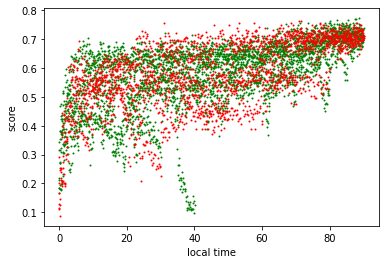

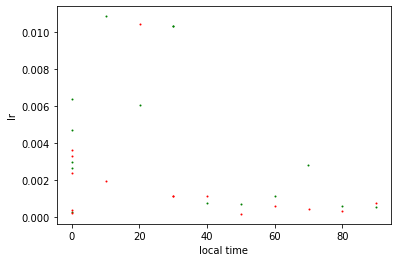

In [ ]:
fig,ax=plt.subplots()
for fm in family_trainers:
    fm.plot_metric("score",ax)

_,ax=plt.subplots()
for fm in family_trainers:
    fm.plot_metric("lr",ax)

plt.show()

### Observons le meilleurs agent de chaque famille

In [ ]:
best_agents=[fm.get_best_agent() for fm in family_trainers]

for agent in best_agents:
    Y_pred=agent.model(XY_DEALER.X_test)
    accuracy = tf.keras.metrics.sparse_categorical_accuracy(XY_DEALER.Y_test, Y_pred)
    print(accuracy.numpy().mean())

0.7174
0.703
